In [13]:
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import warnings
import os
from datetime import datetime
from src.PowerNNRegressor import PowerNNRegressor
from scipy import stats
import torch


warnings.filterwarnings("ignore")

### Parameters

In [14]:
metrics_filename="metrics.csv"
models={}
metrics_model={}

## Grid search with Cross validation

### Loading Data

In [15]:
train_data=pd.read_csv("data/train_prep.csv")
test_data=pd.read_csv("data/test_prep.csv")
#Check if metrics file exists
if os.path.isfile('./'+metrics_filename):
    metrics=pd.read_csv(metrics_filename)
else:
    metrics=pd.DataFrame(columns=["date","model","params","best_train_score","RMSE","MSE","MAE"])

### Training Data


Crossvalidation fold: 1/3

	Epoch: 1/1
		Iter	Loss			Rel. loss
		100	0.07207753	0.0017874602
		200	0.062669754	0.00139959
		300	0.05539167	0.00096503156
		400	0.050049372	0.0007891036
		500	0.04625181	0.00079730985
		600	0.04272401	0.0007797805
		700	0.03963149	0.0007202594
		800	0.036942396	0.00069793395
		900	0.0343848	0.00074602227
		1000	0.031827684	0.0007863957
		Final loss:
		1000	0.031827684	0.0007863957

	Best loss: 0.03182768449187279


Crossvalidation fold: 2/3

	Epoch: 1/1
		Iter	Loss			Rel. loss
		100	0.064450875	0.0016722563
		200	0.054705065	0.0015972644
		300	0.047228657	0.0012501462
		400	0.042072114	0.001058854
		500	0.038298987	0.0008403751
		600	0.035391957	0.0007537111
		700	0.032860167	0.00073600956
		800	0.030562967	0.00071808073
		900	0.028452951	0.0007104344
		1000	0.026526917	0.00069179223
		Final loss:
		1000	0.026526917	0.00069179223

	Best loss: 0.02652691677212715


Crossvalidation fold: 3/3

	Epoch: 1/1
		Iter	Loss			Rel. loss
		100	0.062117845	0.00167225

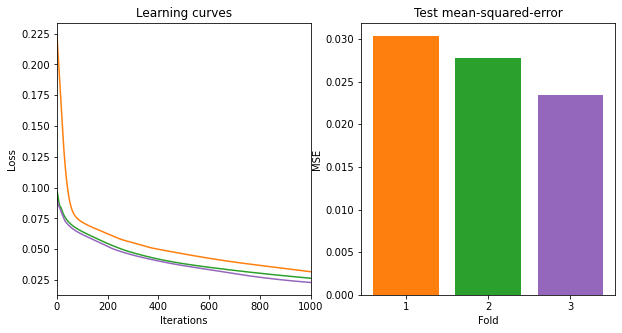

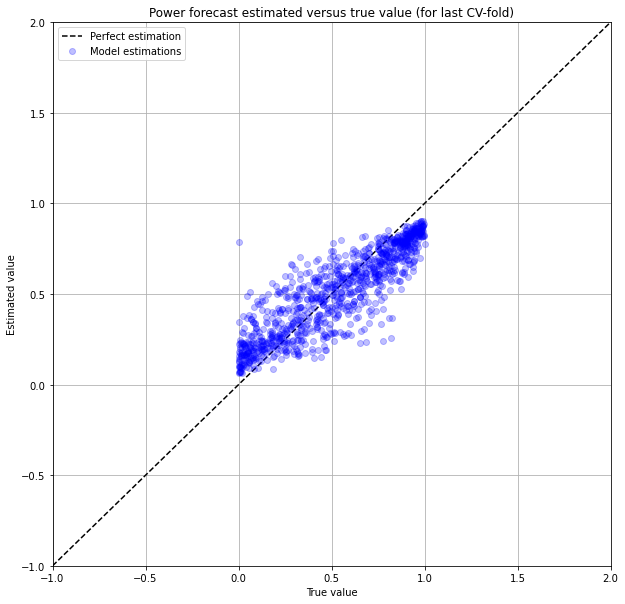

In [16]:
X = train_data[['U10','U100','V10','V100','POWER']]
          
X=np.array(X)
attributeNames=['U10','U100','V10','V100']

y=X[:,[4]] 
X=X[:,0:4]
N, M = X.shape
#C = 2


                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0);
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,0:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 15      # number of hidden units
n_epochs = 1        # number of networks trained in each k-fold
max_iter = 1000        # 

# K-fold crossvalidation
K = 3                   
CV = KFold(K, shuffle=True)


summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))

color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
        torch.nn.Tanh(),   # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),# n_hidden_units to 1 output neuron
        torch.nn.Sigmoid() #2nd tranfer function
        
        )


#Instanciate the model
nn_model=PowerNNRegressor(model,"regression",n_epochs,max_iter)

errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.float)
    
    # Train the net on training data
    best_net, best_final_loss, best_learning_curve = nn_model.train(X_train,y_train)
    
    print('\n\tBest loss: {}\n'.format(best_final_loss))
    
    # Determine estimated class labels for test set
    nn_model.load_state_dict(best_net)
    y_test_est = nn_model(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(best_learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE');
summaries_axes[1].set_title('Test mean-squared-error')   


# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))


plt.figure(figsize=(10,10));
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy();
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true[0:1000], y_est[0:1000],'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Power forecast estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()
plt.show()